### How do the perceived income moments correlate with other individual variables 

- this notebook runs regressions to inspects the covariants of individual perceived income moments
  - individual demogrpahics, level of household income, education, etc.
  - job-types, part-time vs full-time, selfemployment, etc. 
  - other expectations: probability of unemployment, other job-related expectations 
- it examiens both nominal and real income growth 


###  1. Loading and cleaning data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

In [2]:
"""
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png','jpg')
#plt.rcParams['savefig.dpi'] = 75

#plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
#plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
"""

'\nfrom IPython.display import set_matplotlib_formats\nset_matplotlib_formats(\'pdf\',\'png\',\'jpg\')\n#plt.rcParams[\'savefig.dpi\'] = 75\n\n#plt.rcParams[\'figure.autolayout\'] = False\nplt.rcParams[\'figure.figsize\'] = 10, 6\nplt.rcParams[\'axes.labelsize\'] = 18\nplt.rcParams[\'axes.titlesize\'] = 20\n#plt.rcParams[\'font.size\'] = 16\nplt.rcParams[\'lines.linewidth\'] = 2.0\nplt.rcParams[\'lines.markersize\'] = 8\nplt.rcParams[\'legend.fontsize\'] = 14\n\nplt.rcParams[\'text.usetex\'] = True\nplt.rcParams[\'font.family\'] = "serif"\nplt.rcParams[\'font.serif\'] = "cm"\n'

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

In [5]:
## panel data 

#dataset.index = dataset[['date','userid']]

In [6]:
## variable list by catogrories 

vars_id = ['userid','date']

moms_nom = ['Q24_mean','Q24_var']

moms_real = ['Q24_rmean','Q24_rvar']

vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36']  ## education (1-8 low to high, 9 other)

## these variables are only available for a sub sample 

vars_empexp = ['Q13new']  ## probability of unemployment 

vars_macroexp = ['Q6new',  ## stock market going up 
                 'Q4new']  ## UE goes up 

In [7]:
## subselect variables 

vars_all_reg_long = (vars_id+moms_nom + moms_real + vars_job + 
                     vars_demog + vars_demog_sub + 
                     vars_empexp + vars_macroexp)

## select dataset 

SCEM = dataset[vars_all_reg_long]
SCEM.describe(include='all')

,userid,date,Q24_mean,Q24_var,Q24_rmean,Q24_rvar,Q10_1,Q10_2,Q12new,D6,Q32,Q33,Q36,Q13new,Q6new,Q4new
count,"79,064.00",79064,"47,392.00","47,501.00","43,390.00","44,639.00","79,064.00","79,064.00","51,520.00","67,901.00","11,630.00","11,656.00","11,658.00","45,921.00","78,182.00","78,767.00"
unique,nan,60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,2013-08-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,1769,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,nan,2013-06-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,nan,2018-05-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,"70,059,680.73",NaN,2.82,5.56,-0.35,13.47,0.55,0.14,1.13,6.46,50.13,1.52,4.36,14.85,42.80,37.41
std,"20,176.72",NaN,2.37,11.12,3.09,19.82,0.50,0.34,0.34,2.72,16.58,0.50,1.55,20.41,23.08,22.77
min,"70,000,220.00",NaN,-1.00,0.28,-12.24,0.61,0.00,0.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00
25%,"70,044,346.00",NaN,1.00,0.36,-2.00,1.67,0.00,0.00,1.00,4.00,38.00,1.00,3.00,1.00,25.00,20.00


In [8]:
## renaming 

SCEM = SCEM.rename(columns={'Q24_mean': 'incexp',
                           'Q24_var': 'incvar',
                           'Q24_iqr': 'inciqr',
                           'Q24_rmean':'rincexp',
                           'Q24_rvar': 'rincvar'})

SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q13new':'UEprobInd',
                              'Q6new':'Stkprob',
                              'Q4new':'UEprobAgg',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

SCEM.columns

Index(['userid', 'date', 'incexp', 'incvar', 'rincexp', 'rincvar', 'fulltime',
       'parttime', 'selfemp', 'HHinc', 'age', 'gender', 'educ', 'UEprobInd',
       'Stkprob', 'UEprobAgg'],
      dtype='object')

### 2. Correlation pattern 

In [9]:
SCEM.dtypes

userid                int32
date         datetime64[ns]
incexp              float64
incvar              float64
rincexp             float32
rincvar             float32
fulltime               int8
parttime               int8
selfemp             float64
HHinc               float64
age                 float64
gender              float64
educ                float64
UEprobInd           float64
Stkprob             float64
UEprobAgg           float64
dtype: object

In [10]:
for col in ['HHinc','age','educ']:
    SCEM[col] = SCEM[col].astype('int64',errors = 'ignore')

In [11]:
inc_grp = {1:"10k",
           2:'20k',
           3:'30k',
           4:'40k',
           5:'50k',
           6:'60k',
           7:'75k',
           8:'100k',
           9:'150k',
           10:'200k',
           11:'200k+'}

cleanup_nums = {'parttime': {0: 'no', 1: 'yes'},
                'fulltime': {0: 'no', 1: 'yes'},
                'selfemp':{1: 'no', 2: 'yes'},
                'gender':{1:'male',2:'female'}}
SCEM.replace(cleanup_nums,
             inplace = True)

In [12]:
## categorical variables 

vars_cat = ['HHinc','fulltime','parttime','selfemp','gender','educ','userid','date']

for var in vars_cat:
    SCEM[var] = pd.Categorical(SCEM[var],ordered = False)

In [13]:
#pp = sns.pairplot(SCEM)

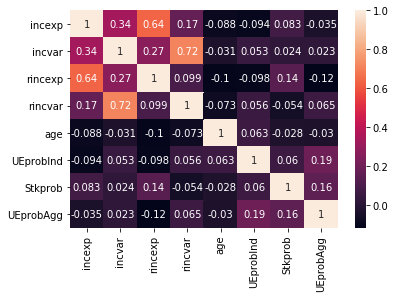

In [14]:
sns.heatmap(SCEM.corr(), annot=True)

###  3. Histograms

In [15]:
## by income group 

fontsize = 80
figsize = (100,50)

"""
for mom in ['incvar','rincvar']:
    for gp in ['HHinc','educ','gender']:
        plt.style.use('seaborn-poster')
        SCEM.boxplot(column=[mom],
                     figsize = figsize,
                     by = gp,
                     patch_artist = True,
                     fontsize = fontsize)
        plt.xlabel(gp,
                   fontsize = fontsize)
        plt.ylabel(mom,
                   fontsize = fontsize)
        plt.ylim(0,40)
        plt.suptitle('')
        plt.title(mom, fontsize= fontsize)
        plt.savefig('../Graphs/ind/boxplot'+str(mom)+'_'+str(gp)+'.jpg')
        
"""

"\nfor mom in ['incvar','rincvar']:\n    for gp in ['HHinc','educ','gender']:\n        plt.style.use('seaborn-poster')\n        SCEM.boxplot(column=[mom],\n                     figsize = figsize,\n                     by = gp,\n                     patch_artist = True,\n                     fontsize = fontsize)\n        plt.xlabel(gp,\n                   fontsize = fontsize)\n        plt.ylabel(mom,\n                   fontsize = fontsize)\n        plt.ylim(0,40)\n        plt.suptitle('')\n        plt.title(mom, fontsize= fontsize)\n        plt.savefig('../Graphs/ind/boxplot'+str(mom)+'_'+str(gp)+'.jpg')\n        \n"

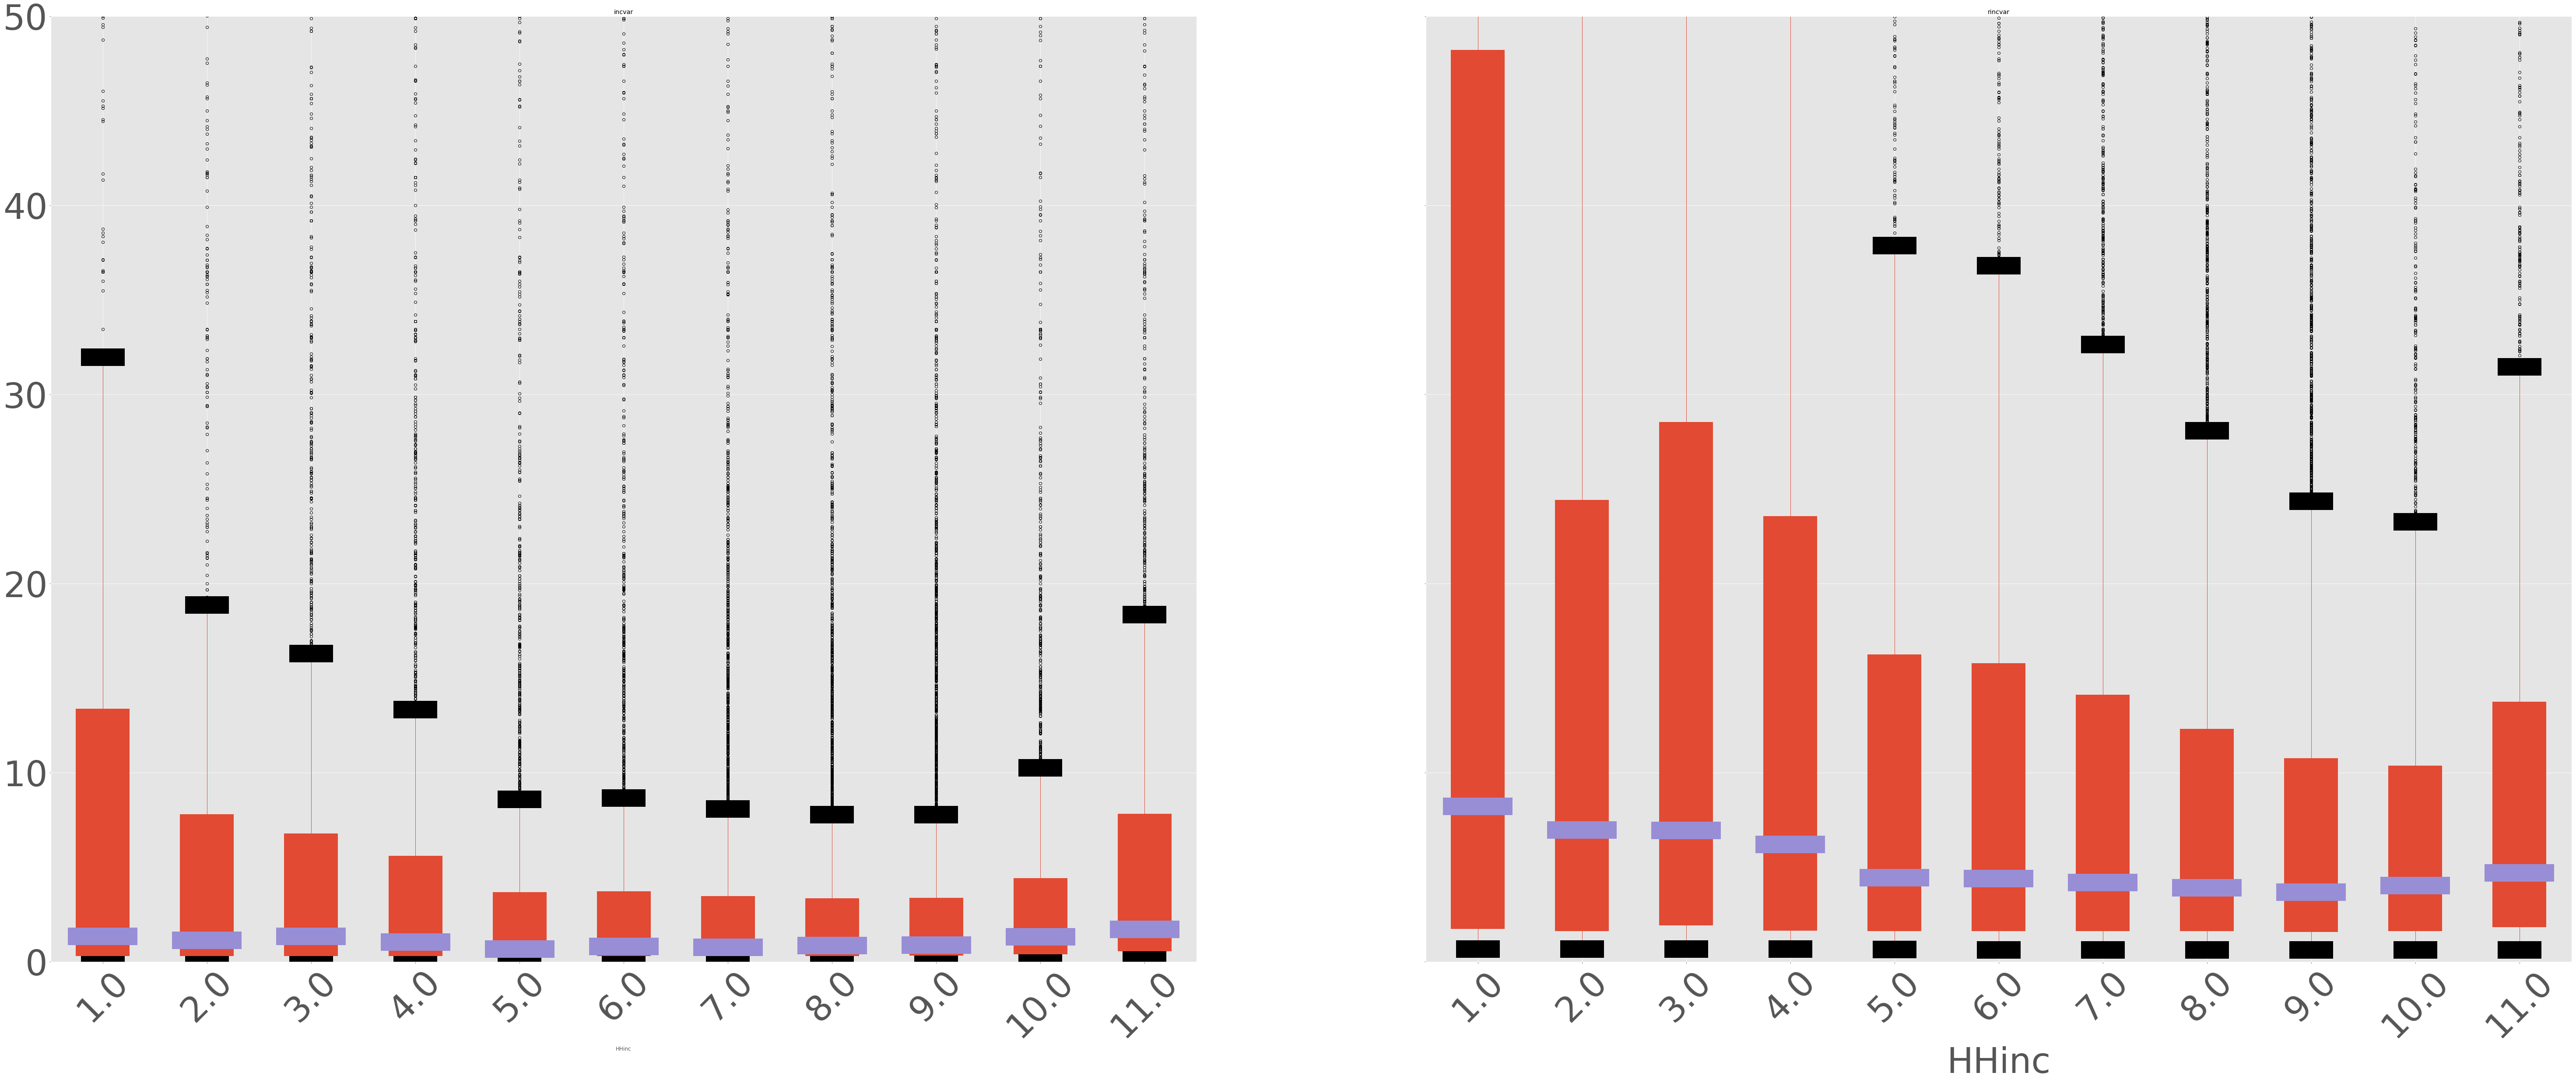

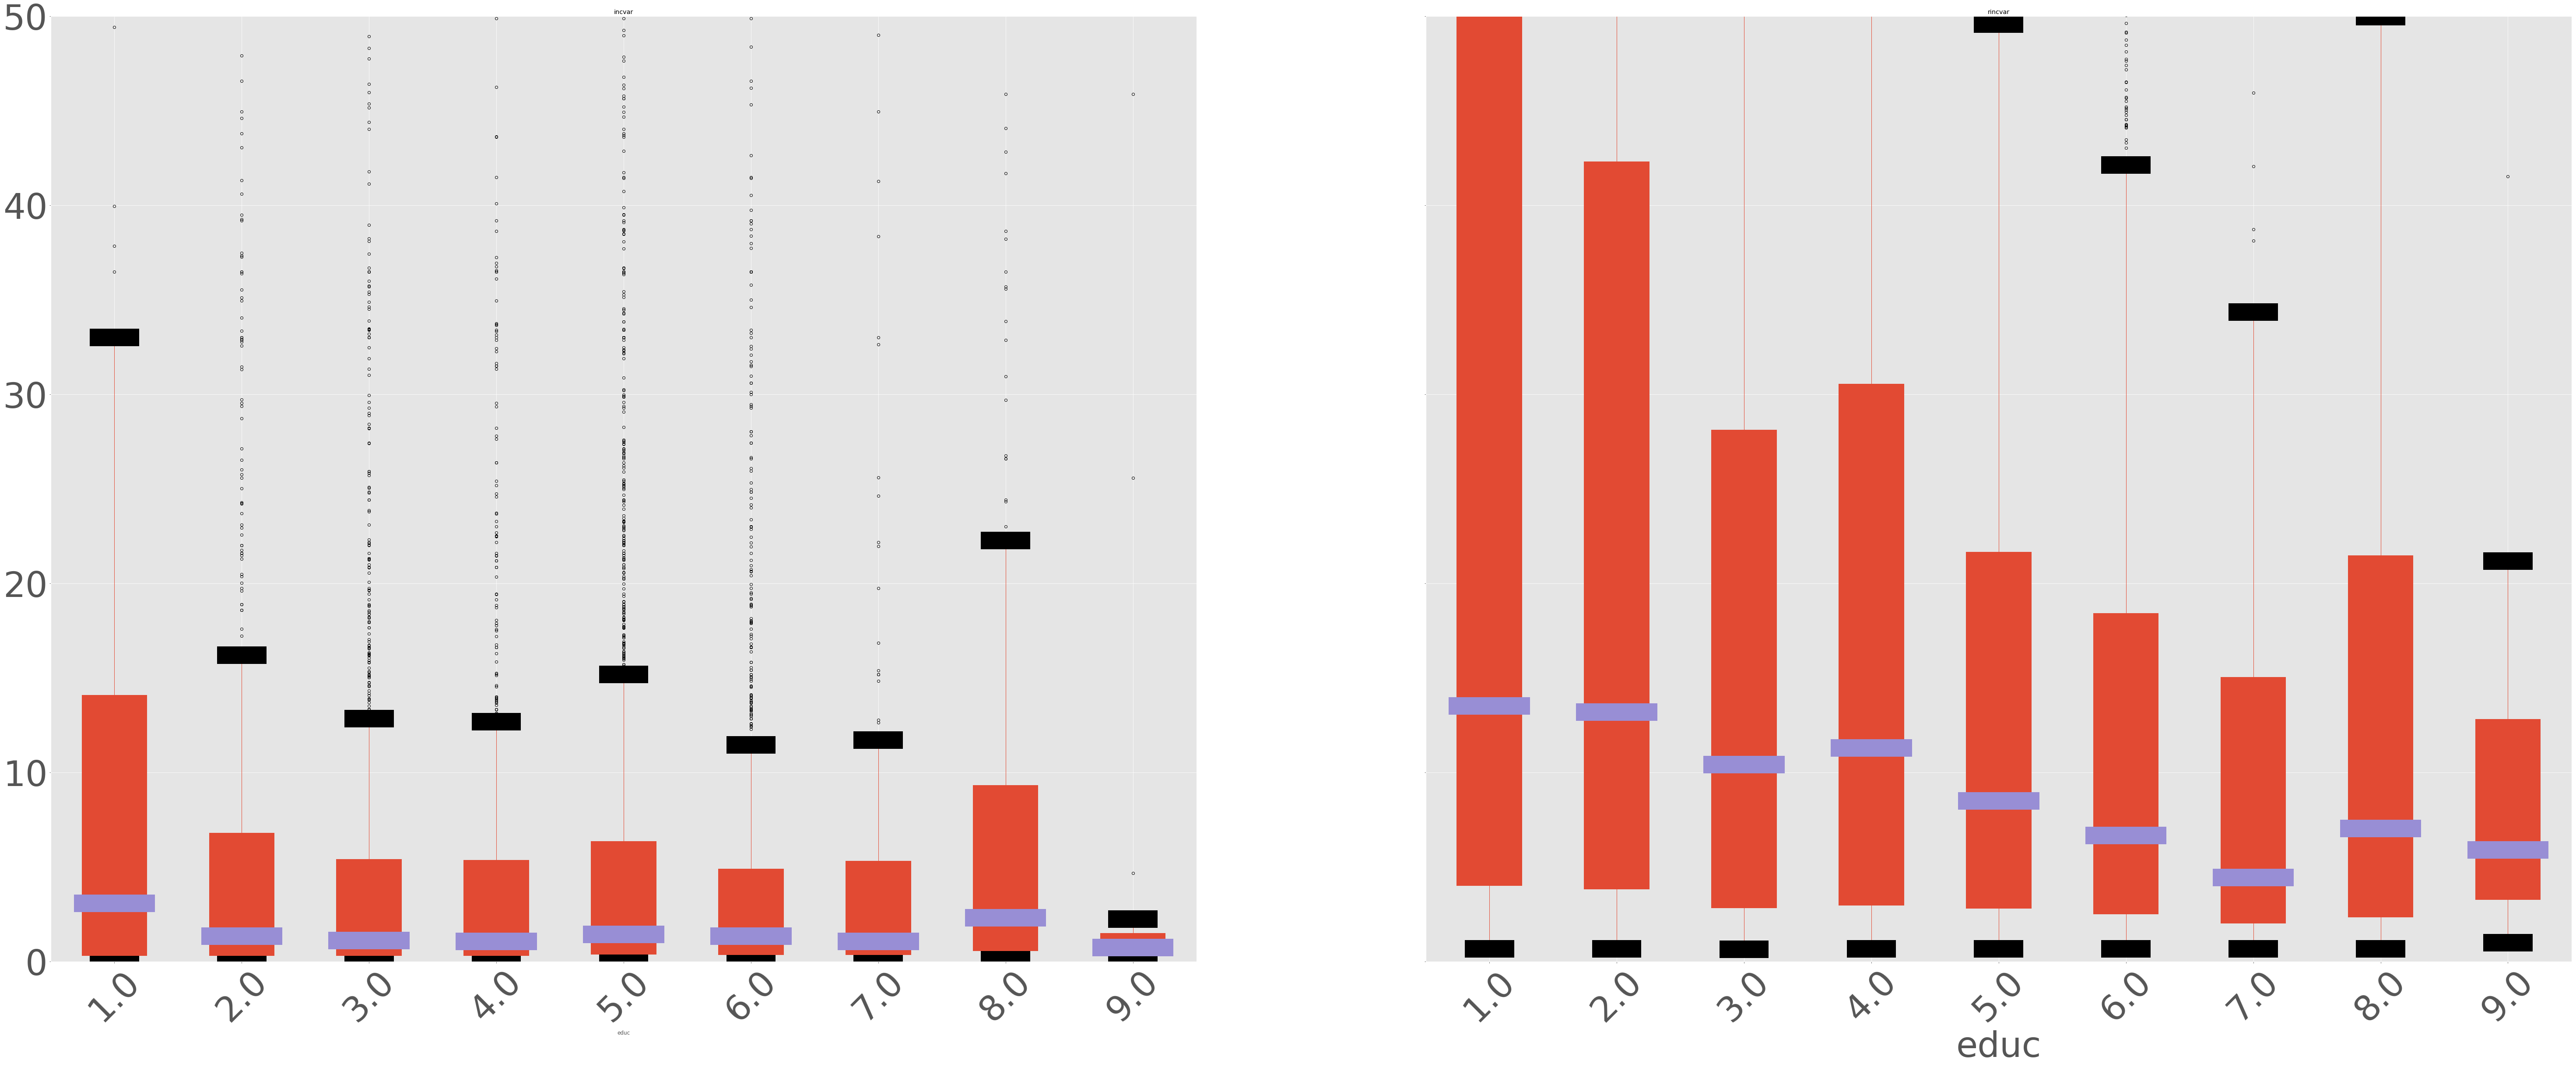

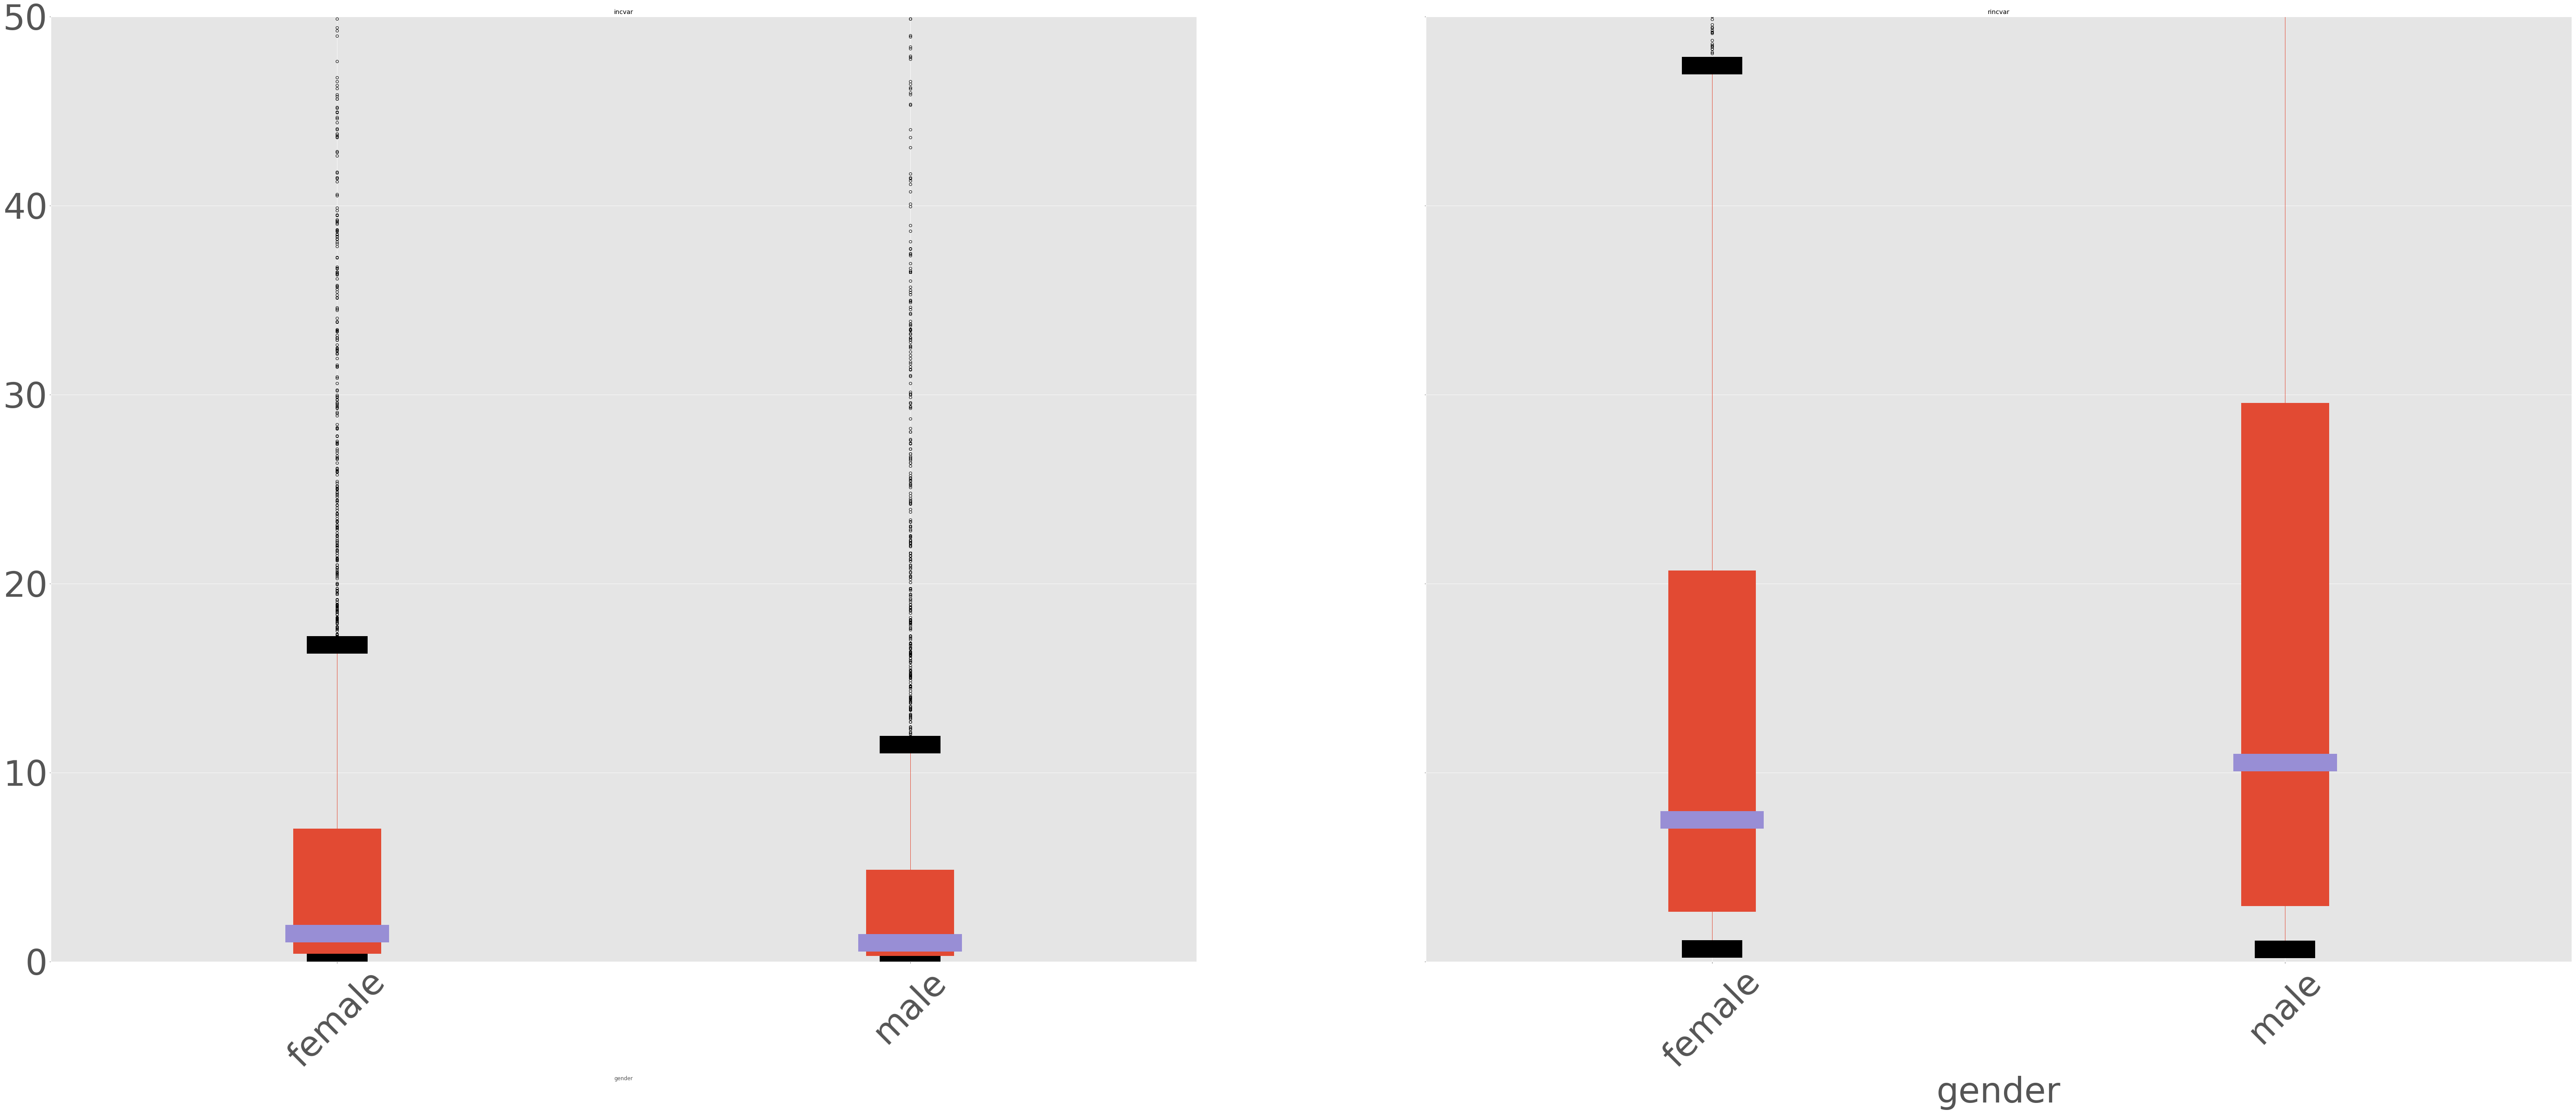

In [16]:
fontsize = 80
figsize = (100,40)
plt.style.use('ggplot')


for gp in ['HHinc','educ','gender']:
    bp = SCEM.boxplot(column=['incvar','rincvar'],
                      figsize = figsize,
                      by = gp,
                      patch_artist = True,
                      fontsize = fontsize,
                      layout=(1, 2),
                      rot =45,
                      return_type='dict')
    
    #plt.title(mom, fontsize= fontsize)
    ## adjust width of lines
    [[item.set_linewidth(4) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['means']] for key in bp.keys()]
    #[[item.set_linewidth(40) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(40) for item in bp[key]['caps']] for key in bp.keys()]
    
    ## adjust color 
    #[[item.set_markerfacecolor('r') for item in bp[key]['means']] for key in bp.keys()]
    #[[item.set_color('k') for item in bp[key]['whiskers']] for key in bp.keys()]
    
    
    plt.xlabel(gp,fontsize = fontsize)
    plt.ylabel('var', fontsize = fontsize)
    plt.ylim(0,50)
    plt.suptitle('')
    ## save figure 
    plt.savefig('../Graphs/ind/boxplot'+'_'+str(gp)+'.jpg')

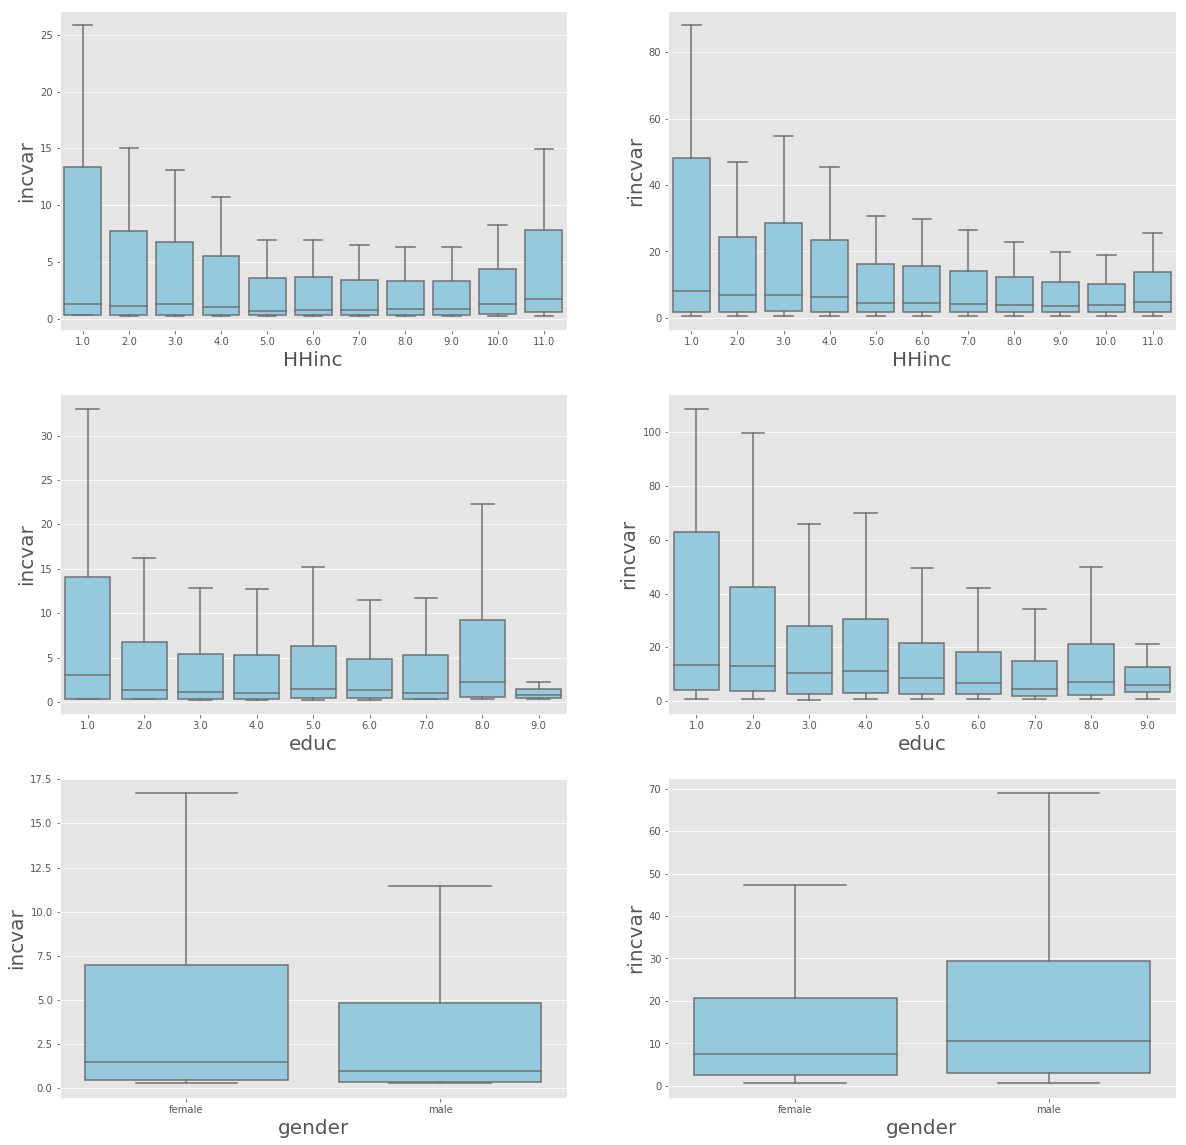

In [17]:
gplist = ['HHinc','educ','gender']
momlist = ['incvar','rincvar']
incg_lb = list(inc_grp.values())


## plot 

fig,axes = plt.subplots(3,2,figsize =(20,20))

for i in range(3):
    for j in range(2):
        gp = gplist[i]
        mom = momlist[j]
        if gplist[i] =='HHinc':
            bp = sns.boxplot(x = gp,
                            y = mom,
                            data = SCEM, 
                            color = 'skyblue',
                            ax = axes[i,j],
                            whis = True,
                            showfliers = False)
        else:
            bp = sns.boxplot(x = gp,
                             y = mom,
                             data = SCEM,
                             color = 'skyblue',
                             ax = axes[i,j],
                             showfliers = False)
            
        # settings 
        bp.set_xlabel(gp,fontsize = 20)
        #bp.xtick_label(fontsize=20)
        bp.set_ylabel(mom,fontsize = 20)
        
plt.savefig('../Graphs/ind/boxplot.jpg')

###  4. Regressions

In [18]:
## preps 

dep_list =  ['incvar','rincvar'] 
dep_list2 =['incexp','rincexp']
indep_list_ct = ['UEprobInd','UEprobInd','Stkprob']
indep_list_dc = ['HHinc','selfemp','fulltime']

In [19]:
## full-table for risks  

rs_list = {}  ## list to store results 
nb_spc = 4  ## number of specifications 

for i,mom in enumerate(dep_list):
    ## model 1 
    model = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp)',
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    ## model 2
    ct_str = '+'.join([var for var in indep_list_ct])
    model2 = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp) + '
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+1] = model2.fit()
    
    ## model 3 
    model3 = smf.ols(formula = str(mom)
                    +'~ C(parttime) + C(selfemp) + C(HHinc) +'
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+2] = model3.fit()
    
    ## model 4 
    model4 = smf.ols(formula = str(mom)
                    +'~ C(gender)+ C(educ)',
                    data = SCEM)
    rs_list[nb_spc*i+3] = model4.fit()
    
    
rs_names = [rs_list[i] for i in range(len(rs_list))]

dfoutput = summary_col(rs_names,
                        float_format='%0.2f',
                        stars = True,
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput.title = 'Perceived Income Risks'
print(dfoutput)

                                          Perceived Income Risks
                   incvar I incvar II incvar III incvar IIII rincvar I rincvar II rincvar III rincvar IIII
----------------------------------------------------------------------------------------------------------
C(HHinc)[T.10.0]                      -4.32***                                    -13.64***               
                                      (0.54)                                      (1.08)                  
C(HHinc)[T.11.0]                      -2.23***                                    -11.70***               
                                      (0.55)                                      (1.10)                  
C(HHinc)[T.2.0]                       -1.25**                                     -3.52***                
                                      (0.59)                                      (1.18)                  
C(HHinc)[T.3.0]                       -1.63***                                 

In [20]:
## output tables 

beginningtex = """
\\begin{table}[ht]
\\centering
\\begin{adjustbox}{width={0.9\\textwidth},totalheight={\\textheight}}
\\begin{threeparttable}
\\caption{Perceived Income Risks and Individual Characteristics}
\\label{micro_reg}"""

endtex = """\\begin{tablenotes}\item Standard errors are clustered by date. *** p$<$0.001, ** p$<$0.01 and * p$<$0.05. 
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""

In [21]:
## relabel rows 


def CatRename(table):
    relabels = {}
    rows = [idx for idx in table.index if ')[T.' in idx]
    for i in range(len(rows)):
        string = rows[i]
        var = string.split('C(')[1].split(')[T')[0]
        val = string.split('[T.')[1].split(']')[0]
        if '.0' in val:
            val = val.split('.0')[0]
        else:
            val = val 
        relabels[rows[i]] = var + '=' + str(val)
    table = table.rename(index = relabels)
    return table 

table = CatRename(dfoutput.tables[0])

In [22]:
## excluding rows that are not to be exported 

to_drop = ['Intercept']

## need to also drop rows reporting the stadard deviations as well 
rows_below = []
for var in to_drop:
    row_idx = list(table.index).index(var)
    #print(row_idx)
    rows_below.append(row_idx) 
    
tb = table.drop(index = to_drop)

In [23]:
## write to latex 
f = open('../Tables/latex/micro_reg.tex', 'w')
f.write(beginningtex)
tb_ltx = tb.to_latex().replace('lllllllll','ccccccccc')   # hard coded here 
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()

In [24]:
## full-table for expected growth, appendix 

## full-table for risks  

rs_list = {}  ## list to store results 
nb_spc = 4  ## number of specifications 

for i,mom in enumerate(dep_list2):
    ## model 1 
    model = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp)',
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    ## model 2
    ct_str = '+'.join([var for var in indep_list_ct])
    model2 = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp) + '
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+1] = model2.fit()
    
    ## model 3 
    model3 = smf.ols(formula = str(mom)
                    +'~ C(parttime) + C(selfemp) + C(HHinc) +'
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+2] = model3.fit()
    
    ## model 4 
    model4 = smf.ols(formula = str(mom)
                    +'~ C(gender)+ C(educ)',
                    data = SCEM)
    rs_list[nb_spc*i+3] = model4.fit()
    
    
rs_names2 = [rs_list[i] for i in range(len(rs_list))]

dfoutput2 = summary_col(rs_names2,
                        float_format='%0.2f',
                        stars = True,
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput2.title = 'Perceived Income Growth'
print(dfoutput2)

## relabel 
table = CatRename(dfoutput2.tables[0])


## drop 
to_drop = ['Intercept']

## need to also drop rows reporting the stadard deviations as well 
rows_below = []
for var in to_drop:
    row_idx = list(table.index).index(var)
    #print(row_idx)
    rows_below.append(row_idx) 
    
tb = table.drop(index = to_drop)

## latex setting 


beginningtex = """
\\begin{table}[ht]
\\centering
\\begin{adjustbox}{width={0.9\\textwidth},totalheight={\\textheight}}
\\begin{threeparttable}
\\caption{Perceived Income Growth and Individual Characteristics}
\\label{micro_reg_exp}"""

endtex = """\\begin{tablenotes}\item Standard errors are clustered by date. *** p$<$0.001, ** p$<$0.01 and * p$<$0.05. 
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""


## write to latex 
f = open('../Tables/latex/micro_reg_exp.tex', 'w')
f.write(beginningtex)
tb_ltx = tb.to_latex().replace('lllllllll','ccccccccc')   # hard coded here 
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()

                                         Perceived Income Growth
                   incexp I incexp II incexp III incexp IIII rincexp I rincexp II rincexp III rincexp IIII
----------------------------------------------------------------------------------------------------------
C(HHinc)[T.10.0]                      0.43***                                     0.66***                 
                                      (0.12)                                      (0.17)                  
C(HHinc)[T.11.0]                      0.74***                                     1.20***                 
                                      (0.12)                                      (0.17)                  
C(HHinc)[T.2.0]                       0.02                                        -0.27                   
                                      (0.13)                                      (0.18)                  
C(HHinc)[T.3.0]                       0.34***                                  